In [1]:
#!/usr/bin/env python

from nbformat import write
import rospy
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d,Axes3D
from human_prediction.quat_functions import *
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, minkowski
from human_prediction.network import *
from std_msgs.msg import Float32MultiArray
import rospkg
from human_prediction.skeleton import *
from scipy import interpolate as interp
import time
from scipy.signal import butter, lfilter

In [2]:

if __name__ == '__main__':

    this_pack = os.path.split(os.getcwd())[0]
    print(this_pack)

    file_num_str = '400,4100'
    print(file_num_str)
    print(type(file_num_str)==int)
    if not type(file_num_str)==int:
        file_num_range = np.array(file_num_str.split(',')).astype(int)
    else:
        file_num_range = np.array([file_num_str])
    print(file_num_range)
    file_nums = []
    if (file_num_range.shape[0]==1):
        if (file_num_range[0]==-1):
            rec_nums = np.array([0])
            for filename in os.listdir(os.path.join(this_pack,'data')):
                # print(filename)
                if filename.startswith('recording_'):
                    if filename.endswith('.csv'):
                        file_parts = filename.split('_')
                        rec_nums = np.append(rec_nums,file_parts[1].split('.')[0])
            file_num = np.max(rec_nums.astype(int))
        else:
            file_num = file_num_range[0]
        file_nums.append(file_num)
    else:
        all_files = os.listdir(os.path.join(this_pack,'data'))
        for i in range(file_num_range[0],file_num_range[1]+1):
            if 'recording_{}.csv'.format(i) in all_files:
                file_nums.append(i)
    print(file_nums)
    # for filename in os.listdir(os.path.join(this_pack,'data')):
    #     if filename.startswith('recording_') and filename.endswith('.csv'):
    #         file_parts = filename.split('_')
    #         file_num = int(file_parts[1].split('.')[0])
    #         if file_num<80:
    #             continue
    #     else:
    #         continue
    speeds = np.empty((0))
    final_errors = np.empty((0))
    start_delays = np.empty((0))
    peak_vels = np.empty((0))
    dists = np.empty((0))
    durations = np.empty((0))
    for file_num in file_nums:
        prediction = np.genfromtxt(os.path.join(this_pack,'data','prediction_{}.csv'.format(file_num)),dtype=float,delimiter=',')
        print('opening recording_{}'.format(file_num))
        data = np.genfromtxt(os.path.join(this_pack,'data','recording_{}.csv'.format(file_num)),dtype=float,delimiter=',')
        if data.shape[0]==0:
            continue
        if (data.shape[0]>800):
            print('record {} is over 8 seconds, skipping'.format(file_num))
            continue
        if data[0,1]<data[0,5]:
            wrist = False
            print('right')
        else:
            wrist = True
            print('left')
        l_wrist_vels = np.linalg.norm(np.diff(data[:,[60,61,62]],axis=0),axis=1)
        r_wrist_vels = np.linalg.norm(np.diff(data[:,[51,52,53]],axis=0),axis=1)
        l_wrist_errors = np.linalg.norm(data[:,[60,61,62]]-data[:,[1,2,3]],axis=1)
        r_wrist_errors = np.linalg.norm(data[:,[51,52,53]]-data[:,[1,2,3]],axis=1)
   
        l_wrist_error_avg = np.zeros_like(l_wrist_errors)
        r_wrist_error_avg = np.zeros_like(r_wrist_errors)
        l_wrist_error_vels_avg = np.zeros_like(l_wrist_error_avg)
        r_wrist_error_vels_avg = np.zeros_like(r_wrist_error_avg)
        d_starts =np.empty((0))
        filt = butter(1, 0.001, btype='lowpass', analog=False)
        # d_starts.append(0)
        d_stops = np.empty((0))
        in_div = False
        v1s =np.zeros_like(r_wrist_error_avg)
        v2s =np.zeros_like(r_wrist_error_avg)
        m = 20
        d_start = 0
        accs = np.zeros_like(r_wrist_error_avg)
        num_sgn_flips = 0
        first_sgn_flip = 0
        max_deviation = 0
        min_out_dev = 10
        tmp_start = 0
        initial_error=0
        for i in range(l_wrist_errors.shape[0]):
            l_wrist_error_avg[i] = np.mean(l_wrist_errors[max(i-20,0):i+1])
            r_wrist_error_avg[i] = np.mean(r_wrist_errors[max(i-20,0):i+1])
            if i==0:
                if wrist:
                    initial_error = l_wrist_error_avg[i]
                else:
                    initial_error = r_wrist_error_avg[i]
            # print('i:{},in_div:{}'.format(i,in_div))
            # print('m1:{}'.format(r_wrist_error_avg[i]))
            if i>0:
                l_wrist_error_vels_avg[i] = np.mean(np.diff(l_wrist_error_avg[max(i-50,0):i+1]))
                r_wrist_error_vels_avg[i] = np.mean(np.diff(r_wrist_error_avg[max(i-50,0):i+1]))
                if wrist:
                    accs[i] = np.mean(np.diff(l_wrist_error_vels_avg[max(i-20,0):i+1]))
                else:
                    accs[i] = np.mean(np.diff(r_wrist_error_vels_avg[max(i-20,0):i+1]))
            else: 
                l_wrist_error_vels_avg[i] = 0
                r_wrist_error_vels_avg[i] = 0
                accs[i] = 0
            # print('m2:{}'.format(r_wrist_error_vels_avg[i]))
            if wrist:
                d = l_wrist_error_vels_avg[:i+1]
                w_error = l_wrist_error_avg[i]
            else:
                d = r_wrist_error_vels_avg[:i+1]
                w_error = r_wrist_error_avg[i]
            v1 = np.mean(d[-m:])

            v1s[i] = v1
            # v1s.append(lfilter(filt[0],filt[1],d[-20:])[-1])
            v2 = np.mean(d[-2*m:-m])
            v2s[i] = v2
            v3 = np.mean(d[-m:])
            v4 = np.mean(d[-2*m:-m])
            # print('v1:{}'.format(v1))
            # print('v2:{}'.format(v2))
            # print('v3:{}'.format(v3))
            # print('v4:{}'.format(v4))
            sgn_flip = (i>m+5) and (v1s[i]<v2s[i]) and (v1s[max(i-1,0)]>v2s[max(i-1,0)]) #!= np.sign([v1s[max(i-1,0)]-v2s[max(i-1,0)]]))
            max_deviation = max(np.max(np.abs([v1,v2,v3,v4])),max_deviation)
            # print('i:{}{},{},sgn_flip:{},{},{}'.format(i,in_div,max_deviation,sgn_flip, np.sign([v1s[i]-v2s[i]]),np.sign([v1s[max(i-1,0)]-v2s[max(i-1,0)]])))
            if d_stops.shape[0]>0:
                last_stop = d_stops[-1]
            else:
                last_stop = 0
            if d_starts.shape[0]>0:
                last_start = d_starts[-1]
            else:
                last_start = 0
            if ((((v1<0) and (v2>0)) or ((v1>0) and (v2<0))) or sgn_flip):
                if in_div and sgn_flip:
                    num_sgn_flips+=1
                if (not in_div) and sgn_flip:
                    first_sgn_flip = i
                if (not in_div) and ((i-last_stop)>min_out_dev) and (last_stop-d_start<100):
                    max_deviation = 0
                    tmp_start = i
                    in_div = True
                if (in_div) and ((max_deviation<0.0002) or (w_error>initial_error-0.02)) and (w_error>0.2):
                    # if d_stops.shape[0]>0:
                    #     if (i-d_stops[-1])>min_out_dev:
                    #         d_starts =np.append(d_starts,i)
                    #         print('start1:{}'.format(i))
                    # else:
                    d_starts =np.append(d_starts,i)
                    # print('start2:{}'.format(i))

            if in_div:
                if (i-last_start>50) and (((v3>0) and (v4<0)) or ((v3<0) and (v4>0))) and (max_deviation>0.001):
                    in_div = False
                    d_stops = np.append(d_stops,i)
                    if d_starts.shape[0]>0:
                        d_start = d_starts[-1] - min(i,m)
                    else:
                        d_start = 0
                    # print('stop:{}'.format(i))
        # v1s = lfilter(filt[0],filt[1],l_wrist_error_vels_avg)
        if in_div and (max_deviation>0.001):
                d_stops = np.append(d_stops,l_wrist_errors.shape[0]-1)
                if d_starts.shape[0]>0:
                    d_start = d_starts[-1] - min(i,m)
                else:
                    d_start = 0
        if len(d_stops)==0:
            d_stops = np.append(d_stops,l_wrist_errors.shape[0]-1)
        if d_stops[-1] < l_wrist_errors.shape[0]-1:
            d_stop = d_stops[-1] - min(i,m)
        else:
            d_stop = d_stops[-1]
        print('d_starts:{},d_stops:{}, {}, {}'.format(d_start,d_stop,num_sgn_flips,first_sgn_flip))

    
        acc_var = np.var(accs[np.abs(accs - np.mean(accs))<2*np.std(accs)])
        if wrist:
            final_error = l_wrist_error_avg[int(d_stop)]
        else:
            final_error = r_wrist_error_avg[int(d_stop)]
        
        if (final_error<0.2) and (acc_var<3E-8):
            duration = (d_stop-d_start)*0.011
            durations = np.append(durations,duration)
            start_delays = np.append(start_delays,d_start*0.011)
            if wrist:
                dist = np.linalg.norm(data[int(d_stop),[60,61,62]]-data[int(d_start),[60,61,62]])
                dists = np.append(dists,dist)
                final_errors = np.append(final_errors,np.min(l_wrist_errors[int(d_start):int(d_stop)]))
                peak_vels = np.append(peak_vels,np.max(np.abs(l_wrist_error_vels_avg)))
            else:
                dist = np.linalg.norm(data[int(d_stop),[60,61,62]]-data[int(d_start),[51,52,63]])
                dists = np.append(dists,dist)
                final_errors = np.append(final_errors,np.min(r_wrist_errors[int(d_start):int(d_stop)]))
                peak_vels = np.append(peak_vels,np.max(np.abs(r_wrist_error_vels_avg)))
            speeds = np.append(speeds,dist/duration)
            print('rec {}, duration:{:.3}, dist:{:.3}, speed:{:.3}'.format(file_num,duration,dist,dist/duration))
            record_cols = np.concatenate((np.arange(1,4),np.arange(5,36))).astype(int)
            record_rows = np.arange(d_start,d_stop+1).astype(int)
            print('rec {} not saved'.format(file_num))



/home/jared.flowers@ad.ufl.edu/projects/test_ws/src/human_prediction
400,4100
False
[ 400 4100]
[400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580

/home/jared.flowers@ad.ufl.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jared.flowers@ad.ufl.edu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


record 406 is over 8 seconds, skipping
opening recording_407
right
d_starts:27.0,d_stops:273.0, 1, 47
rec 407, duration:2.71, dist:0.973, speed:0.36
rec 407 not saved
opening recording_408
right
d_starts:56.0,d_stops:233.0, 0, 611
rec 408, duration:1.95, dist:0.211, speed:0.108
rec 408 not saved
opening recording_409
right
d_starts:45.0,d_stops:204.0, 0, 589
rec 409, duration:1.75, dist:0.469, speed:0.268
rec 409 not saved
opening recording_410
right
d_starts:37.0,d_stops:336.0, 2, 0
rec 410, duration:3.29, dist:0.24, speed:0.0729
rec 410 not saved
opening recording_411
right
d_starts:56.0,d_stops:259.0, 1, 0
rec 411, duration:2.23, dist:0.321, speed:0.144
rec 411 not saved
opening recording_412
right
d_starts:101.0,d_stops:238.0, 0, 121
opening recording_413
right
d_starts:69.0,d_stops:201.0, 1, 321
rec 413, duration:1.45, dist:0.416, speed:0.287
rec 413 not saved
opening recording_414
right
d_starts:91.0,d_stops:342.0, 3, 733
opening recording_415
record 415 is over 8 seconds, skippi

right
d_starts:121.0,d_stops:404.0, 4, 0
rec 481, duration:3.11, dist:0.667, speed:0.214
rec 481 not saved
opening recording_482
right
d_starts:168.0,d_stops:312.0, 1, 0
rec 482, duration:1.58, dist:0.753, speed:0.475
rec 482 not saved
opening recording_483
right
d_starts:173.0,d_stops:420.0, 0, 155
rec 483, duration:2.72, dist:0.738, speed:0.271
rec 483 not saved
opening recording_484
right
d_starts:72.0,d_stops:207.0, 1, 0
rec 484, duration:1.48, dist:0.515, speed:0.347
rec 484 not saved
opening recording_485
right
d_starts:14.0,d_stops:202.0, 1, 34
rec 485, duration:2.07, dist:0.525, speed:0.254
rec 485 not saved
opening recording_486
right
d_starts:24.0,d_stops:203.0, 1, 44
rec 486, duration:1.97, dist:0.317, speed:0.161
rec 486 not saved
opening recording_487
right
d_starts:66.0,d_stops:228.0, 0, 318
rec 487, duration:1.78, dist:0.293, speed:0.164
rec 487 not saved
opening recording_488
right
d_starts:47.0,d_stops:172.0, 1, 0
rec 488, duration:1.38, dist:0.321, speed:0.233
rec 488

d_starts:28.0,d_stops:214.0, 0, 0
rec 555, duration:2.05, dist:0.644, speed:0.315
rec 555 not saved
opening recording_556
right
d_starts:50.0,d_stops:272.0, 0, 0
rec 556, duration:2.44, dist:1.1, speed:0.45
rec 556 not saved
opening recording_557
right
d_starts:46.0,d_stops:173.0, 0, 0
rec 557, duration:1.4, dist:0.419, speed:0.3
rec 557 not saved
opening recording_558
right
d_starts:44.0,d_stops:182.0, 1, 0
rec 558, duration:1.52, dist:0.235, speed:0.155
rec 558 not saved
opening recording_559
right
d_starts:33.0,d_stops:229.0, 1, 0
rec 559, duration:2.16, dist:0.16, speed:0.0741
rec 559 not saved
opening recording_560
right
d_starts:45.0,d_stops:247.0, 0, 0
rec 560, duration:2.22, dist:0.0714, speed:0.0321
rec 560 not saved
opening recording_561
right
d_starts:72.0,d_stops:224.0, 2, 0
rec 561, duration:1.67, dist:0.265, speed:0.158
rec 561 not saved
opening recording_562
right
d_starts:70.0,d_stops:232.0, 1, 0
rec 562, duration:1.78, dist:0.287, speed:0.161
rec 562 not saved
opening 

d_starts:58.0,d_stops:342.0, 2, 399
opening recording_626
right
d_starts:15.0,d_stops:208.0, 1, 280
rec 626, duration:2.12, dist:0.369, speed:0.174
rec 626 not saved
opening recording_627
right
d_starts:14.0,d_stops:203.0, 1, 680
rec 627, duration:2.08, dist:0.588, speed:0.283
rec 627 not saved
opening recording_628
right
d_starts:65.0,d_stops:226.0, 0, 0
rec 628, duration:1.77, dist:0.621, speed:0.35
rec 628 not saved
opening recording_629
right
d_starts:71.0,d_stops:220.0, 0, 91
rec 629, duration:1.64, dist:0.632, speed:0.386
rec 629 not saved
opening recording_630
right
d_starts:42.0,d_stops:203.0, 0, 0
rec 630, duration:1.77, dist:0.625, speed:0.353
rec 630 not saved
opening recording_631
right
d_starts:0,d_stops:203.0, 0, 0
rec 631, duration:2.23, dist:1.01, speed:0.451
rec 631 not saved
opening recording_632
right
d_starts:29.0,d_stops:190.0, 0, 49
rec 632, duration:1.77, dist:0.737, speed:0.416
rec 632 not saved
opening recording_633
right
d_starts:34.0,d_stops:233.0, 1, 0
rec 6

right
d_starts:85.0,d_stops:367.0, 1, 105
rec 701, duration:3.1, dist:0.214, speed:0.0691
rec 701 not saved
opening recording_702
right
d_starts:37.0,d_stops:247.0, 1, 43
rec 702, duration:2.31, dist:0.403, speed:0.174
rec 702 not saved
opening recording_703
right
d_starts:53.0,d_stops:221.0, 1, 0
rec 703, duration:1.85, dist:0.464, speed:0.251
rec 703 not saved
opening recording_704
record 704 is over 8 seconds, skipping
opening recording_705
right
d_starts:62.0,d_stops:144.0, 1, 0
rec 705, duration:0.902, dist:0.471, speed:0.522
rec 705 not saved
opening recording_706
right
d_starts:43.0,d_stops:192.0, 0, 615
rec 706, duration:1.64, dist:0.781, speed:0.477
rec 706 not saved
opening recording_707
right
d_starts:59.0,d_stops:210.0, 0, 0
rec 707, duration:1.66, dist:0.912, speed:0.549
rec 707 not saved
opening recording_708
right
d_starts:37.0,d_stops:215.0, 1, 0
rec 708, duration:1.96, dist:0.973, speed:0.497
rec 708 not saved
opening recording_709
right
d_starts:59.0,d_stops:313.0, 2,

opening recording_777
right
d_starts:4.0,d_stops:198.0, 0, 0
rec 777, duration:2.13, dist:0.525, speed:0.246
rec 777 not saved
opening recording_778
right
d_starts:0,d_stops:217.0, 0, 0
rec 778, duration:2.39, dist:0.562, speed:0.236
rec 778 not saved
opening recording_779
right
d_starts:84.0,d_stops:242.0, 2, 0
rec 779, duration:1.74, dist:0.415, speed:0.239
rec 779 not saved
opening recording_780
right
d_starts:79.0,d_stops:236.0, 0, 99
rec 780, duration:1.73, dist:0.467, speed:0.27
rec 780 not saved
opening recording_781
right
d_starts:67.0,d_stops:219.0, 0, 75
rec 781, duration:1.67, dist:0.39, speed:0.233
rec 781 not saved
opening recording_782
right
d_starts:24.0,d_stops:214.0, 1, 44
rec 782, duration:2.09, dist:0.48, speed:0.23
rec 782 not saved
opening recording_783
right
d_starts:57.0,d_stops:243.0, 0, 77
rec 783, duration:2.05, dist:0.467, speed:0.228
rec 783 not saved
opening recording_784
right
d_starts:52.0,d_stops:227.0, 1, 0
rec 784, duration:1.92, dist:0.474, speed:0.24

d_starts:84.0,d_stops:305.0, 1, 77
rec 847, duration:2.43, dist:0.882, speed:0.363
rec 847 not saved
opening recording_848
right
d_starts:33.0,d_stops:149.0, 0, 53
rec 848, duration:1.28, dist:0.419, speed:0.328
rec 848 not saved
opening recording_849
right
d_starts:15.0,d_stops:161.0, 1, 0
rec 849, duration:1.61, dist:0.428, speed:0.266
rec 849 not saved
opening recording_850
right
d_starts:58.0,d_stops:195.0, 1, 56
rec 850, duration:1.51, dist:0.44, speed:0.292
rec 850 not saved
opening recording_851
right
d_starts:61.0,d_stops:237.0, 1, 281
rec 851, duration:1.94, dist:0.258, speed:0.133
rec 851 not saved
opening recording_852
right
d_starts:69.0,d_stops:213.0, 1, 47
rec 852, duration:1.58, dist:0.237, speed:0.149
rec 852 not saved
opening recording_853
right
d_starts:80.0,d_stops:244.0, 0, 92
rec 853, duration:1.8, dist:0.219, speed:0.121
rec 853 not saved
opening recording_854
right
d_starts:69.0,d_stops:230.0, 1, 0
rec 854, duration:1.77, dist:0.457, speed:0.258
rec 854 not saved

opening recording_913
right
d_starts:91.0,d_stops:272.0, 2, 0
rec 913, duration:1.99, dist:0.404, speed:0.203
rec 913 not saved
opening recording_914
right
d_starts:91.0,d_stops:256.0, 1, 37
rec 914, duration:1.81, dist:0.45, speed:0.248
rec 914 not saved
opening recording_915
right
d_starts:79.0,d_stops:246.0, 1, 0
rec 915, duration:1.84, dist:0.488, speed:0.266
rec 915 not saved
opening recording_916
right
d_starts:61.0,d_stops:245.0, 0, 0
rec 916, duration:2.02, dist:0.533, speed:0.263
rec 916 not saved
opening recording_917
right
d_starts:38.0,d_stops:283.0, 1, 0
rec 917, duration:2.69, dist:0.595, speed:0.221
rec 917 not saved
opening recording_918
right
d_starts:72.0,d_stops:248.0, 1, 0
rec 918, duration:1.94, dist:0.376, speed:0.194
rec 918 not saved
opening recording_919
right
d_starts:95.0,d_stops:293.0, 1, 0
rec 919, duration:2.18, dist:0.71, speed:0.326
rec 919 not saved
opening recording_920
right
d_starts:79.0,d_stops:325.0, 1, 0
rec 920, duration:2.71, dist:0.688, speed:0

d_starts:27.0,d_stops:196.0, 0, 299
rec 982, duration:1.86, dist:0.835, speed:0.449
rec 982 not saved
opening recording_983
right
d_starts:43.0,d_stops:173.0, 1, 0
rec 983, duration:1.43, dist:0.8, speed:0.56
rec 983 not saved
opening recording_984
right
d_starts:27.0,d_stops:197.0, 0, 47
rec 984, duration:1.87, dist:0.92, speed:0.492
rec 984 not saved
opening recording_985
right
d_starts:44.0,d_stops:228.0, 1, 502
rec 985, duration:2.02, dist:0.643, speed:0.318
rec 985 not saved
opening recording_986
right
d_starts:0,d_stops:186.0, 0, 230
rec 986, duration:2.05, dist:0.73, speed:0.357
rec 986 not saved
opening recording_987
right
d_starts:36.0,d_stops:184.0, 0, 0
rec 987, duration:1.63, dist:0.609, speed:0.374
rec 987 not saved
opening recording_988
right
d_starts:61.0,d_stops:198.0, 2, 246
rec 988, duration:1.51, dist:0.562, speed:0.373
rec 988 not saved
opening recording_989
right
d_starts:44.0,d_stops:195.0, 2, 387
rec 989, duration:1.66, dist:0.568, speed:0.342
rec 989 not saved
o

d_starts:43.0,d_stops:198.0, 0, 249
rec 1056, duration:1.7, dist:0.632, speed:0.371
rec 1056 not saved
opening recording_1057
right
d_starts:68.0,d_stops:156.0, 0, 300
opening recording_1058
right
d_starts:69.0,d_stops:181.0, 0, 707
opening recording_1059
right
d_starts:0,d_stops:71.0, 0, 0
opening recording_1060
right
d_starts:36.0,d_stops:236.0, 0, 0
rec 1060, duration:2.2, dist:0.291, speed:0.132
rec 1060 not saved
opening recording_1061
right
d_starts:58.0,d_stops:251.0, 0, 45
rec 1061, duration:2.12, dist:0.264, speed:0.125
rec 1061 not saved
opening recording_1062
right
d_starts:21.0,d_stops:256.0, 1, 0
rec 1062, duration:2.58, dist:0.273, speed:0.105
rec 1062 not saved
opening recording_1063
right
d_starts:55.0,d_stops:279.0, 1, 0
rec 1063, duration:2.46, dist:0.318, speed:0.129
rec 1063 not saved
opening recording_1064
right
d_starts:30.0,d_stops:285.0, 0, 50
rec 1064, duration:2.8, dist:0.351, speed:0.125
rec 1064 not saved
opening recording_1065
right
d_starts:39.0,d_stops:30

right
d_starts:0,d_stops:171.0, 0, 160
opening recording_1131
right
d_starts:70.0,d_stops:355.0, 1, 70
rec 1131, duration:3.13, dist:0.599, speed:0.191
rec 1131 not saved
opening recording_1132
right
d_starts:63.0,d_stops:309.0, 0, 62
rec 1132, duration:2.71, dist:0.69, speed:0.255
rec 1132 not saved
opening recording_1133
right
d_starts:60.0,d_stops:201.0, 0, 254
rec 1133, duration:1.55, dist:0.743, speed:0.479
rec 1133 not saved
opening recording_1134
right
d_starts:57.0,d_stops:170.0, 0, 210
rec 1134, duration:1.24, dist:0.786, speed:0.632
rec 1134 not saved
opening recording_1135
left
d_starts:0,d_stops:463.0, 3, 97
opening recording_1136
right
d_starts:11.0,d_stops:148.0, 0, 204
opening recording_1137
right
d_starts:52.0,d_stops:179.0, 0, 361
opening recording_1138
right
d_starts:63.0,d_stops:261.0, 0, 321
rec 1138, duration:2.18, dist:0.313, speed:0.144
rec 1138 not saved
opening recording_1139
right
d_starts:13.0,d_stops:314.0, 2, 0
rec 1139, duration:3.31, dist:0.415, speed:0.1

d_starts:85.0,d_stops:432.0, 3, 57
rec 1200, duration:3.82, dist:0.683, speed:0.179
rec 1200 not saved
opening recording_1201
right
d_starts:62.0,d_stops:252.0, 1, 309
rec 1201, duration:2.09, dist:0.704, speed:0.337
rec 1201 not saved
opening recording_1202
right
d_starts:83.0,d_stops:267.0, 0, 0
rec 1202, duration:2.02, dist:0.444, speed:0.219
rec 1202 not saved
opening recording_1203
right
d_starts:39.0,d_stops:208.0, 0, 265
rec 1203, duration:1.86, dist:0.592, speed:0.318
rec 1203 not saved
opening recording_1204
right
d_starts:27.0,d_stops:290.0, 0, 0
rec 1204, duration:2.89, dist:0.877, speed:0.303
rec 1204 not saved
opening recording_1205
right
d_starts:62.0,d_stops:288.0, 1, 0
rec 1205, duration:2.49, dist:0.761, speed:0.306
rec 1205 not saved
opening recording_1206
right
d_starts:78.0,d_stops:220.0, 1, 289
opening recording_1207
left
d_starts:308.0,d_stops:335.0, 2, 0
opening recording_1208
right
d_starts:54.0,d_stops:333.0, 0, 0
rec 1208, duration:3.07, dist:1.06, speed:0.345

d_starts:8.0,d_stops:268.0, 0, 329
rec 1269, duration:2.86, dist:0.371, speed:0.13
rec 1269 not saved
opening recording_1270
right
d_starts:94.0,d_stops:211.0, 0, 288
rec 1270, duration:1.29, dist:0.299, speed:0.232
rec 1270 not saved
opening recording_1271
right
d_starts:52.0,d_stops:231.0, 0, 270
rec 1271, duration:1.97, dist:0.451, speed:0.229
rec 1271 not saved
opening recording_1272
right
d_starts:33.0,d_stops:255.0, 2, 0
rec 1272, duration:2.44, dist:0.714, speed:0.292
rec 1272 not saved
opening recording_1273
right
d_starts:41.0,d_stops:174.0, 1, 385
rec 1273, duration:1.46, dist:0.467, speed:0.319
rec 1273 not saved
opening recording_1274
right
d_starts:76.0,d_stops:217.0, 1, 252
rec 1274, duration:1.55, dist:0.702, speed:0.453
rec 1274 not saved
opening recording_1275
right
d_starts:37.0,d_stops:240.0, 0, 0
rec 1275, duration:2.23, dist:0.928, speed:0.416
rec 1275 not saved
opening recording_1276
right
d_starts:47.0,d_stops:214.0, 1, 255
rec 1276, duration:1.84, dist:0.945, sp

d_starts:15.0,d_stops:144.0, 0, 187
rec 1337, duration:1.42, dist:0.516, speed:0.364
rec 1337 not saved
opening recording_1338
right
d_starts:16.0,d_stops:166.0, 0, 395
rec 1338, duration:1.65, dist:0.703, speed:0.426
rec 1338 not saved
opening recording_1339
right
d_starts:58.0,d_stops:333.0, 3, 33
rec 1339, duration:3.02, dist:0.81, speed:0.268
rec 1339 not saved
opening recording_1340
right
d_starts:28.0,d_stops:235.0, 2, 0
rec 1340, duration:2.28, dist:0.536, speed:0.235
rec 1340 not saved
opening recording_1341
right
d_starts:39.0,d_stops:279.0, 1, 0
rec 1341, duration:2.64, dist:0.635, speed:0.241
rec 1341 not saved
opening recording_1342
right
d_starts:28.0,d_stops:232.0, 1, 0
rec 1342, duration:2.24, dist:0.639, speed:0.285
rec 1342 not saved
opening recording_1343
right
d_starts:35.0,d_stops:180.0, 0, 224
rec 1343, duration:1.59, dist:0.286, speed:0.179
rec 1343 not saved
opening recording_1344
right
d_starts:38.0,d_stops:255.0, 1, 308
rec 1344, duration:2.39, dist:0.462, spee

right
d_starts:17.0,d_stops:249.0, 0, 285
rec 1402, duration:2.55, dist:0.676, speed:0.265
rec 1402 not saved
opening recording_1403
right
d_starts:18.0,d_stops:277.0, 0, 0
rec 1403, duration:2.85, dist:0.737, speed:0.259
rec 1403 not saved
opening recording_1404
right
d_starts:15.0,d_stops:303.0, 1, 35
rec 1404, duration:3.17, dist:0.568, speed:0.179
rec 1404 not saved
opening recording_1405
right
d_starts:21.0,d_stops:315.0, 0, 41
rec 1405, duration:3.23, dist:0.566, speed:0.175
rec 1405 not saved
opening recording_1406
right
d_starts:6.0,d_stops:320.0, 1, 26
rec 1406, duration:3.45, dist:0.463, speed:0.134
rec 1406 not saved
opening recording_1407
right
d_starts:47.0,d_stops:353.0, 0, 0
rec 1407, duration:3.37, dist:0.569, speed:0.169
rec 1407 not saved
opening recording_1408
right
d_starts:41.0,d_stops:355.0, 1, 61
rec 1408, duration:3.45, dist:0.849, speed:0.246
rec 1408 not saved
opening recording_1409
right
d_starts:0,d_stops:60.0, 2, 0
opening recording_1410
record 1410 is over

d_starts:11.0,d_stops:206.0, 0, 270
rec 1471, duration:2.15, dist:0.858, speed:0.4
rec 1471 not saved
opening recording_1472
right
d_starts:10.0,d_stops:220.0, 0, 264
rec 1472, duration:2.31, dist:0.444, speed:0.192
rec 1472 not saved
opening recording_1473
right
d_starts:14.0,d_stops:323.0, 1, 485
rec 1473, duration:3.4, dist:0.459, speed:0.135
rec 1473 not saved
opening recording_1474
right
d_starts:58.0,d_stops:247.0, 1, 307
rec 1474, duration:2.08, dist:0.668, speed:0.321
rec 1474 not saved
opening recording_1475
right
d_starts:17.0,d_stops:270.0, 0, 311
rec 1475, duration:2.78, dist:0.942, speed:0.338
rec 1475 not saved
opening recording_1476
right
d_starts:46.0,d_stops:305.0, 1, 0
rec 1476, duration:2.85, dist:0.835, speed:0.293
rec 1476 not saved
opening recording_1477
right
d_starts:35.0,d_stops:241.0, 0, 0
rec 1477, duration:2.27, dist:0.637, speed:0.281
rec 1477 not saved
opening recording_1478
right
d_starts:11.0,d_stops:316.0, 2, 31
rec 1478, duration:3.35, dist:1.12, speed

left
d_starts:41.0,d_stops:304.0, 1, 0
rec 1540, duration:2.89, dist:0.527, speed:0.182
rec 1540 not saved
opening recording_1541
left
d_starts:50.0,d_stops:182.0, 0, 234
rec 1541, duration:1.45, dist:0.99, speed:0.682
rec 1541 not saved
opening recording_1542
left
d_starts:12.0,d_stops:179.0, 0, 224
rec 1542, duration:1.84, dist:0.885, speed:0.482
rec 1542 not saved
opening recording_1543
left
d_starts:60.0,d_stops:185.0, 0, 234
rec 1543, duration:1.38, dist:0.862, speed:0.627
rec 1543 not saved
opening recording_1544
left
d_starts:50.0,d_stops:220.0, 1, 267
rec 1544, duration:1.87, dist:0.65, speed:0.348
rec 1544 not saved
opening recording_1545
left
d_starts:19.0,d_stops:235.0, 0, 277
rec 1545, duration:2.38, dist:0.822, speed:0.346
rec 1545 not saved
opening recording_1546
left
d_starts:12.0,d_stops:219.0, 0, 282
rec 1546, duration:2.28, dist:0.819, speed:0.36
rec 1546 not saved
opening recording_1547
left
d_starts:54.0,d_stops:237.0, 1, 323
rec 1547, duration:2.01, dist:1.06, spee

d_starts:60.0,d_stops:244.0, 0, 302
rec 1606, duration:2.02, dist:0.732, speed:0.362
rec 1606 not saved
opening recording_1607
left
d_starts:22.0,d_stops:180.0, 0, 231
rec 1607, duration:1.74, dist:0.777, speed:0.447
rec 1607 not saved
opening recording_1608
left
d_starts:37.0,d_stops:263.0, 0, 57
rec 1608, duration:2.49, dist:0.887, speed:0.357
rec 1608 not saved
opening recording_1609
left
d_starts:58.0,d_stops:224.0, 0, 266
opening recording_1610
left
d_starts:54.0,d_stops:227.0, 1, 289
rec 1610, duration:1.9, dist:0.61, speed:0.32
rec 1610 not saved
opening recording_1611
left
d_starts:64.0,d_stops:218.0, 0, 272
rec 1611, duration:1.69, dist:0.757, speed:0.447
rec 1611 not saved
opening recording_1612
left
d_starts:56.0,d_stops:276.0, 1, 0
rec 1612, duration:2.42, dist:0.831, speed:0.343
rec 1612 not saved
opening recording_1613
left
d_starts:72.0,d_stops:300.0, 0, 59
rec 1613, duration:2.51, dist:0.825, speed:0.329
rec 1613 not saved
opening recording_1614
left
d_starts:29.0,d_sto

d_starts:40.0,d_stops:209.0, 0, 388
rec 1674, duration:1.86, dist:0.629, speed:0.338
rec 1674 not saved
opening recording_1675
left
d_starts:15.0,d_stops:192.0, 0, 341
rec 1675, duration:1.95, dist:0.771, speed:0.396
rec 1675 not saved
opening recording_1676
left
d_starts:29.0,d_stops:205.0, 0, 326
rec 1676, duration:1.94, dist:0.847, speed:0.438
rec 1676 not saved
opening recording_1677
left
d_starts:21.0,d_stops:288.0, 1, 352
rec 1677, duration:2.94, dist:1.05, speed:0.356
rec 1677 not saved
opening recording_1678
left
d_starts:23.0,d_stops:202.0, 1, 514
rec 1678, duration:1.97, dist:1.09, speed:0.555
rec 1678 not saved
opening recording_1679
left
d_starts:31.0,d_stops:280.0, 1, 0
rec 1679, duration:2.74, dist:0.5, speed:0.183
rec 1679 not saved
opening recording_1680
left
d_starts:29.0,d_stops:183.0, 0, 305
rec 1680, duration:1.69, dist:0.563, speed:0.332
rec 1680 not saved
opening recording_1681
left
d_starts:21.0,d_stops:157.0, 0, 227
rec 1681, duration:1.5, dist:0.547, speed:0.36

d_starts:88.0,d_stops:275.0, 1, 108
rec 1742, duration:2.06, dist:0.226, speed:0.11
rec 1742 not saved
opening recording_1743
left
d_starts:27.0,d_stops:274.0, 1, 47
rec 1743, duration:2.72, dist:0.436, speed:0.16
rec 1743 not saved
opening recording_1744
left
d_starts:46.0,d_stops:222.0, 2, 0
rec 1744, duration:1.94, dist:0.306, speed:0.158
rec 1744 not saved
opening recording_1745
left
d_starts:0,d_stops:106.0, 0, 158
rec 1745, duration:1.17, dist:0.201, speed:0.172
rec 1745 not saved
opening recording_1746
left
d_starts:16.0,d_stops:174.0, 0, 281
rec 1746, duration:1.74, dist:0.348, speed:0.2
rec 1746 not saved
opening recording_1747
left
d_starts:45.0,d_stops:175.0, 0, 234
rec 1747, duration:1.43, dist:0.4, speed:0.279
rec 1747 not saved
opening recording_1748
left
d_starts:8.0,d_stops:166.0, 1, 226
rec 1748, duration:1.74, dist:0.636, speed:0.366
rec 1748 not saved
opening recording_1749
left
d_starts:11.0,d_stops:205.0, 1, 263
rec 1749, duration:2.13, dist:0.643, speed:0.301
rec 

record 1812 is over 8 seconds, skipping
opening recording_1813
left
d_starts:21.0,d_stops:262.0, 1, 322
rec 1813, duration:2.65, dist:0.467, speed:0.176
rec 1813 not saved
opening recording_1814
left
d_starts:0,d_stops:263.0, 1, 0
rec 1814, duration:2.89, dist:0.704, speed:0.243
rec 1814 not saved
opening recording_1815
left
d_starts:25.0,d_stops:409.0, 3, 0
rec 1815, duration:4.22, dist:0.731, speed:0.173
rec 1815 not saved
opening recording_1816
left
d_starts:37.0,d_stops:335.0, 1, 0
opening recording_1817
left
d_starts:14.0,d_stops:237.0, 2, 457
opening recording_1818
left
d_starts:41.0,d_stops:203.0, 0, 428
rec 1818, duration:1.78, dist:0.849, speed:0.476
rec 1818 not saved
opening recording_1819
left
d_starts:15.0,d_stops:159.0, 0, 378
rec 1819, duration:1.58, dist:0.253, speed:0.159
rec 1819 not saved
opening recording_1820
left
d_starts:14.0,d_stops:206.0, 1, 247
rec 1820, duration:2.11, dist:0.452, speed:0.214
rec 1820 not saved
opening recording_1821
left
d_starts:51.0,d_stops

d_starts:10.0,d_stops:263.0, 0, 303
rec 1883, duration:2.78, dist:0.976, speed:0.351
rec 1883 not saved
opening recording_1884
left
d_starts:75.0,d_stops:189.0, 1, 236
rec 1884, duration:1.25, dist:0.466, speed:0.372
rec 1884 not saved
opening recording_1885
left
d_starts:14.0,d_stops:252.0, 1, 314
rec 1885, duration:2.62, dist:0.481, speed:0.184
rec 1885 not saved
opening recording_1886
left
d_starts:16.0,d_stops:233.0, 1, 285
rec 1886, duration:2.39, dist:0.455, speed:0.191
rec 1886 not saved
opening recording_1887
left
d_starts:61.0,d_stops:370.0, 1, 0
rec 1887, duration:3.4, dist:0.561, speed:0.165
rec 1887 not saved
opening recording_1888
left
d_starts:59.0,d_stops:321.0, 1, 65
rec 1888, duration:2.88, dist:0.724, speed:0.251
rec 1888 not saved
opening recording_1889
left
d_starts:18.0,d_stops:283.0, 1, 38
rec 1889, duration:2.92, dist:0.825, speed:0.283
rec 1889 not saved
opening recording_1890
left
d_starts:40.0,d_stops:169.0, 0, 469
opening recording_1891
left
d_starts:32.0,d_s

d_starts:38.0,d_stops:255.0, 1, 478
rec 1953, duration:2.39, dist:1.22, speed:0.511
rec 1953 not saved
opening recording_1954
left
d_starts:25.0,d_stops:217.0, 0, 45
rec 1954, duration:2.11, dist:0.536, speed:0.254
rec 1954 not saved
opening recording_1955
left
d_starts:37.0,d_stops:138.0, 0, 181
rec 1955, duration:1.11, dist:0.387, speed:0.348
rec 1955 not saved
opening recording_1956
left
d_starts:6.0,d_stops:160.0, 0, 367
rec 1956, duration:1.69, dist:0.489, speed:0.288
rec 1956 not saved
opening recording_1957
left
d_starts:23.0,d_stops:258.0, 1, 315
rec 1957, duration:2.58, dist:0.403, speed:0.156
rec 1957 not saved
opening recording_1958
left
d_starts:55.0,d_stops:243.0, 1, 300
rec 1958, duration:2.07, dist:0.521, speed:0.252
rec 1958 not saved
opening recording_1959
left
d_starts:33.0,d_stops:320.0, 2, 371
rec 1959, duration:3.16, dist:0.672, speed:0.213
rec 1959 not saved
opening recording_1960
left
d_starts:64.0,d_stops:341.0, 2, 0
rec 1960, duration:3.05, dist:0.911, speed:0.

d_starts:39.0,d_stops:137.0, 0, 178
opening recording_2028
left
d_starts:21.0,d_stops:311.0, 1, 375
rec 2028, duration:3.19, dist:1.26, speed:0.396
rec 2028 not saved
opening recording_2029
left
d_starts:39.0,d_stops:133.0, 0, 339
opening recording_2030
left
d_starts:21.0,d_stops:250.0, 0, 0
rec 2030, duration:2.52, dist:0.85, speed:0.338
rec 2030 not saved
opening recording_2031
left
d_starts:9.0,d_stops:178.0, 0, 229
rec 2031, duration:1.86, dist:0.591, speed:0.318
rec 2031 not saved
opening recording_2032
left
d_starts:31.0,d_stops:206.0, 0, 253
rec 2032, duration:1.92, dist:0.736, speed:0.382
rec 2032 not saved
opening recording_2033
left
d_starts:31.0,d_stops:298.0, 0, 0
rec 2033, duration:2.94, dist:0.818, speed:0.279
rec 2033 not saved
opening recording_2034
left
d_starts:33.0,d_stops:327.0, 1, 53
rec 2034, duration:3.23, dist:1.18, speed:0.364
rec 2034 not saved
opening recording_2035
left
d_starts:40.0,d_stops:313.0, 0, 361
rec 2035, duration:3.0, dist:1.37, speed:0.457
rec 20

d_starts:37.0,d_stops:240.0, 1, 0
rec 2100, duration:2.23, dist:0.65, speed:0.291
rec 2100 not saved
opening recording_2101
left
d_starts:57.0,d_stops:315.0, 1, 0
rec 2101, duration:2.84, dist:0.868, speed:0.306
rec 2101 not saved
opening recording_2102
left
d_starts:53.0,d_stops:271.0, 0, 309
rec 2102, duration:2.4, dist:1.11, speed:0.461
rec 2102 not saved
opening recording_2103
left
d_starts:26.0,d_stops:325.0, 0, 46
rec 2103, duration:3.29, dist:1.27, speed:0.386
rec 2103 not saved
opening recording_2104
left
d_starts:24.0,d_stops:281.0, 1, 44
rec 2104, duration:2.83, dist:0.497, speed:0.176
rec 2104 not saved
opening recording_2105
left
d_starts:10.0,d_stops:249.0, 1, 30
rec 2105, duration:2.63, dist:0.575, speed:0.219
rec 2105 not saved
opening recording_2106
left
d_starts:23.0,d_stops:235.0, 0, 278
rec 2106, duration:2.33, dist:0.669, speed:0.287
rec 2106 not saved
opening recording_2107
left
d_starts:1.0,d_stops:177.0, 1, 222
rec 2107, duration:1.94, dist:0.449, speed:0.232
rec

d_starts:48.0,d_stops:189.0, 0, 240
rec 2166, duration:1.55, dist:0.776, speed:0.5
rec 2166 not saved
opening recording_2167
left
d_starts:43.0,d_stops:158.0, 1, 206
rec 2167, duration:1.26, dist:0.666, speed:0.526
rec 2167 not saved
opening recording_2168
left
d_starts:35.0,d_stops:169.0, 0, 213
rec 2168, duration:1.47, dist:0.431, speed:0.293
rec 2168 not saved
opening recording_2169
left
d_starts:26.0,d_stops:221.0, 0, 270
rec 2169, duration:2.15, dist:0.371, speed:0.173
rec 2169 not saved
opening recording_2170
left
d_starts:69.0,d_stops:297.0, 2, 0
rec 2170, duration:2.51, dist:0.339, speed:0.135
rec 2170 not saved
opening recording_2171
left
d_starts:75.0,d_stops:306.0, 1, 0
rec 2171, duration:2.54, dist:0.873, speed:0.344
rec 2171 not saved
opening recording_2172
left
d_starts:53.0,d_stops:311.0, 0, 0
rec 2172, duration:2.84, dist:0.98, speed:0.345
rec 2172 not saved
opening recording_2173
left
d_starts:50.0,d_stops:334.0, 0, 0
rec 2173, duration:3.12, dist:1.06, speed:0.339
rec

d_starts:30.0,d_stops:278.0, 0, 0
rec 2233, duration:2.73, dist:0.64, speed:0.235
rec 2233 not saved
opening recording_2234
left
d_starts:41.0,d_stops:204.0, 0, 253
rec 2234, duration:1.79, dist:0.613, speed:0.342
rec 2234 not saved
opening recording_2235
left
d_starts:27.0,d_stops:164.0, 0, 208
rec 2235, duration:1.51, dist:0.766, speed:0.508
rec 2235 not saved
opening recording_2236
left
d_starts:60.0,d_stops:174.0, 0, 222
rec 2236, duration:1.25, dist:0.356, speed:0.284
rec 2236 not saved
opening recording_2237
left
d_starts:28.0,d_stops:194.0, 0, 258
rec 2237, duration:1.83, dist:0.379, speed:0.208
rec 2237 not saved
opening recording_2238
left
d_starts:40.0,d_stops:282.0, 1, 0
rec 2238, duration:2.66, dist:0.475, speed:0.178
rec 2238 not saved
opening recording_2239
left
d_starts:12.0,d_stops:305.0, 0, 32
rec 2239, duration:3.22, dist:0.902, speed:0.28
rec 2239 not saved
opening recording_2240
left
d_starts:23.0,d_stops:337.0, 0, 0
rec 2240, duration:3.45, dist:1.01, speed:0.293
r

d_starts:43.0,d_stops:329.0, 0, 63
rec 2298, duration:3.15, dist:0.781, speed:0.248
rec 2298 not saved
opening recording_2299
left
d_starts:39.0,d_stops:269.0, 0, 307
rec 2299, duration:2.53, dist:1.01, speed:0.4
rec 2299 not saved
opening recording_2300
left
d_starts:48.0,d_stops:333.0, 0, 68
rec 2300, duration:3.13, dist:1.19, speed:0.379
rec 2300 not saved
opening recording_2301
left
d_starts:0,d_stops:371.0, 0, 323
rec 2301, duration:4.08, dist:1.22, speed:0.298
rec 2301 not saved
opening recording_2302
left
d_starts:30.0,d_stops:286.0, 1, 0
rec 2302, duration:2.82, dist:0.65, speed:0.231
rec 2302 not saved
opening recording_2303
left
d_starts:0,d_stops:169.0, 0, 211
rec 2303, duration:1.86, dist:0.818, speed:0.44
rec 2303 not saved
opening recording_2304
left
d_starts:15.0,d_stops:250.0, 0, 35
rec 2304, duration:2.58, dist:0.561, speed:0.217
rec 2304 not saved
opening recording_2305
left
d_starts:39.0,d_stops:274.0, 0, 0
rec 2305, duration:2.58, dist:0.686, speed:0.265
rec 2305 no

d_starts:0,d_stops:276.0, 0, 268
rec 2367, duration:3.04, dist:0.749, speed:0.247
rec 2367 not saved
opening recording_2368
left
d_starts:0,d_stops:271.0, 0, 0
rec 2368, duration:2.98, dist:0.771, speed:0.259
rec 2368 not saved
opening recording_2369
left
d_starts:13.0,d_stops:242.0, 1, 0
rec 2369, duration:2.52, dist:0.447, speed:0.178
rec 2369 not saved
opening recording_2370
left
d_starts:19.0,d_stops:212.0, 0, 39
rec 2370, duration:2.12, dist:0.532, speed:0.251
rec 2370 not saved
opening recording_2371
left
d_starts:37.0,d_stops:222.0, 0, 260
rec 2371, duration:2.03, dist:0.768, speed:0.377
rec 2371 not saved
opening recording_2372
left
d_starts:18.0,d_stops:351.0, 1, 38
rec 2372, duration:3.66, dist:1.16, speed:0.317
rec 2372 not saved
opening recording_2373
left
d_starts:25.0,d_stops:265.0, 0, 340
rec 2373, duration:2.64, dist:1.37, speed:0.519
rec 2373 not saved
opening recording_2374
left
d_starts:44.0,d_stops:368.0, 2, 0
rec 2374, duration:3.56, dist:1.14, speed:0.32
rec 2374 

d_starts:38.0,d_stops:160.0, 0, 238
rec 2433, duration:1.34, dist:0.818, speed:0.61
rec 2433 not saved
opening recording_2434
right
d_starts:73.0,d_stops:226.0, 1, 295
rec 2434, duration:1.68, dist:0.847, speed:0.503
rec 2434 not saved
opening recording_2435
right
d_starts:69.0,d_stops:165.0, 0, 275
rec 2435, duration:1.06, dist:0.831, speed:0.787
rec 2435 not saved
opening recording_2436
right
d_starts:79.0,d_stops:238.0, 0, 318
rec 2436, duration:1.75, dist:0.267, speed:0.152
rec 2436 not saved
opening recording_2437
right
d_starts:44.0,d_stops:210.0, 0, 245
rec 2437, duration:1.83, dist:0.709, speed:0.388
rec 2437 not saved
opening recording_2438
right
d_starts:69.0,d_stops:220.0, 0, 454
rec 2438, duration:1.66, dist:0.667, speed:0.402
rec 2438 not saved
opening recording_2439
right
d_starts:68.0,d_stops:203.0, 1, 243
rec 2439, duration:1.48, dist:0.827, speed:0.557
rec 2439 not saved
opening recording_2440
right
d_starts:47.0,d_stops:294.0, 1, 49
rec 2440, duration:2.72, dist:0.715

right
d_starts:36.0,d_stops:176.0, 0, 227
rec 2498, duration:1.54, dist:0.269, speed:0.175
rec 2498 not saved
opening recording_2499
right
d_starts:21.0,d_stops:275.0, 1, 316
rec 2499, duration:2.79, dist:0.418, speed:0.15
rec 2499 not saved
opening recording_2500
right
d_starts:46.0,d_stops:178.0, 0, 306
rec 2500, duration:1.45, dist:0.647, speed:0.446
rec 2500 not saved
opening recording_2501
right
d_starts:72.0,d_stops:200.0, 1, 251
rec 2501, duration:1.41, dist:0.638, speed:0.453
rec 2501 not saved
opening recording_2502
right
d_starts:31.0,d_stops:161.0, 0, 375
rec 2502, duration:1.43, dist:0.632, speed:0.442
rec 2502 not saved
opening recording_2503
right
d_starts:4.0,d_stops:195.0, 1, 245
rec 2503, duration:2.1, dist:1.01, speed:0.48
rec 2503 not saved
opening recording_2504
right
d_starts:20.0,d_stops:206.0, 0, 254
rec 2504, duration:2.05, dist:0.59, speed:0.288
rec 2504 not saved
opening recording_2505
right
d_starts:41.0,d_stops:148.0, 1, 314
rec 2505, duration:1.18, dist:0.7

right
d_starts:31.0,d_stops:197.0, 0, 294
rec 2563, duration:1.83, dist:0.66, speed:0.361
rec 2563 not saved
opening recording_2564
right
d_starts:35.0,d_stops:174.0, 0, 305
rec 2564, duration:1.53, dist:0.403, speed:0.264
rec 2564 not saved
opening recording_2565
right
d_starts:59.0,d_stops:221.0, 1, 260
rec 2565, duration:1.78, dist:0.361, speed:0.203
rec 2565 not saved
opening recording_2566
right
d_starts:29.0,d_stops:191.0, 0, 243
rec 2566, duration:1.78, dist:0.215, speed:0.12
rec 2566 not saved
opening recording_2567
right
d_starts:79.0,d_stops:210.0, 0, 260
rec 2567, duration:1.44, dist:0.681, speed:0.473
rec 2567 not saved
opening recording_2568
right
d_starts:44.0,d_stops:199.0, 0, 244
rec 2568, duration:1.7, dist:0.779, speed:0.457
rec 2568 not saved
opening recording_2569
right
d_starts:43.0,d_stops:155.0, 1, 209
rec 2569, duration:1.23, dist:0.29, speed:0.236
rec 2569 not saved
opening recording_2570
right
d_starts:40.0,d_stops:203.0, 0, 273
rec 2570, duration:1.79, dist:0

right
d_starts:14.0,d_stops:235.0, 0, 281
rec 2630, duration:2.43, dist:0.666, speed:0.274
rec 2630 not saved
opening recording_2631
right
d_starts:32.0,d_stops:212.0, 0, 319
rec 2631, duration:1.98, dist:0.561, speed:0.284
rec 2631 not saved
opening recording_2632
right
d_starts:37.0,d_stops:158.0, 0, 209
rec 2632, duration:1.33, dist:0.229, speed:0.172
rec 2632 not saved
opening recording_2633
right
d_starts:1.0,d_stops:203.0, 1, 267
rec 2633, duration:2.22, dist:0.263, speed:0.118
rec 2633 not saved
opening recording_2634
right
d_starts:44.0,d_stops:295.0, 0, 0
rec 2634, duration:2.76, dist:0.273, speed:0.0988
rec 2634 not saved
opening recording_2635
right
d_starts:23.0,d_stops:257.0, 0, 298
rec 2635, duration:2.57, dist:0.602, speed:0.234
rec 2635 not saved
opening recording_2636
right
d_starts:36.0,d_stops:240.0, 1, 281
rec 2636, duration:2.24, dist:0.542, speed:0.242
rec 2636 not saved
opening recording_2637
right
d_starts:9.0,d_stops:190.0, 0, 310
rec 2637, duration:1.99, dist:

d_starts:0,d_stops:353.0, 3, 0
rec 2697, duration:3.88, dist:0.404, speed:0.104
rec 2697 not saved
opening recording_2698
right
d_starts:48.0,d_stops:240.0, 0, 286
rec 2698, duration:2.11, dist:0.418, speed:0.198
rec 2698 not saved
opening recording_2699
right
d_starts:64.0,d_stops:277.0, 1, 84
rec 2699, duration:2.34, dist:0.289, speed:0.123
rec 2699 not saved
opening recording_2700
right
d_starts:36.0,d_stops:247.0, 0, 307
rec 2700, duration:2.32, dist:0.512, speed:0.221
rec 2700 not saved
opening recording_2701
right
d_starts:43.0,d_stops:211.0, 0, 271
rec 2701, duration:1.85, dist:0.485, speed:0.262
rec 2701 not saved
opening recording_2702
right
d_starts:65.0,d_stops:294.0, 2, 345
rec 2702, duration:2.52, dist:0.327, speed:0.13
rec 2702 not saved
opening recording_2703
right
d_starts:53.0,d_stops:211.0, 0, 254
rec 2703, duration:1.74, dist:0.614, speed:0.354
rec 2703 not saved
opening recording_2704
right
d_starts:26.0,d_stops:323.0, 1, 46
rec 2704, duration:3.27, dist:0.825, spee

right
d_starts:48.0,d_stops:345.0, 1, 0
rec 2768, duration:3.27, dist:0.549, speed:0.168
rec 2768 not saved
opening recording_2769
right
d_starts:24.0,d_stops:275.0, 0, 354
rec 2769, duration:2.76, dist:0.666, speed:0.241
rec 2769 not saved
opening recording_2770
right
d_starts:37.0,d_stops:250.0, 0, 315
rec 2770, duration:2.34, dist:0.795, speed:0.339
rec 2770 not saved
opening recording_2771
record 2771 is over 8 seconds, skipping
opening recording_2772
right
d_starts:13.0,d_stops:227.0, 0, 284
rec 2772, duration:2.35, dist:0.832, speed:0.354
rec 2772 not saved
opening recording_2773
right
d_starts:30.0,d_stops:208.0, 0, 354
rec 2773, duration:1.96, dist:0.826, speed:0.422
rec 2773 not saved
opening recording_2774
right
d_starts:0,d_stops:304.0, 0, 0
rec 2774, duration:3.34, dist:0.542, speed:0.162
rec 2774 not saved
opening recording_2775
right
d_starts:24.0,d_stops:239.0, 0, 302
rec 2775, duration:2.36, dist:0.566, speed:0.239
rec 2775 not saved
opening recording_2776
right
d_start

left
d_starts:47.0,d_stops:198.0, 1, 242
rec 2838, duration:1.66, dist:0.407, speed:0.245
rec 2838 not saved
opening recording_2839
left
d_starts:0,d_stops:132.0, 0, 278
rec 2839, duration:1.45, dist:0.606, speed:0.417
rec 2839 not saved
opening recording_2840
left
d_starts:32.0,d_stops:140.0, 1, 189
rec 2840, duration:1.19, dist:0.763, speed:0.643
rec 2840 not saved
opening recording_2841
left
d_starts:29.0,d_stops:127.0, 0, 323
rec 2841, duration:1.08, dist:0.583, speed:0.541
rec 2841 not saved
opening recording_2842
left
d_starts:45.0,d_stops:285.0, 1, 0
rec 2842, duration:2.64, dist:0.625, speed:0.237
rec 2842 not saved
opening recording_2843
left
d_starts:40.0,d_stops:179.0, 0, 316
rec 2843, duration:1.53, dist:0.338, speed:0.221
rec 2843 not saved
opening recording_2844
left
d_starts:31.0,d_stops:318.0, 0, 51
rec 2844, duration:3.16, dist:0.536, speed:0.17
rec 2844 not saved
opening recording_2845
left
d_starts:25.0,d_stops:295.0, 2, 45
rec 2845, duration:2.97, dist:0.927, speed:

d_starts:21.0,d_stops:170.0, 1, 287
opening recording_2908
left
d_starts:30.0,d_stops:201.0, 0, 266
rec 2908, duration:1.88, dist:1.06, speed:0.565
rec 2908 not saved
opening recording_2909
left
d_starts:44.0,d_stops:233.0, 0, 311
rec 2909, duration:2.08, dist:1.02, speed:0.49
rec 2909 not saved
opening recording_2910
left
d_starts:41.0,d_stops:328.0, 1, 0
rec 2910, duration:3.16, dist:1.42, speed:0.449
rec 2910 not saved
opening recording_2911
left
d_starts:23.0,d_stops:288.0, 0, 336
rec 2911, duration:2.92, dist:1.55, speed:0.531
rec 2911 not saved
opening recording_2912
left
d_starts:9.0,d_stops:324.0, 2, 29
rec 2912, duration:3.46, dist:1.71, speed:0.493
rec 2912 not saved
opening recording_2913
left
d_starts:38.0,d_stops:192.0, 1, 236
rec 2913, duration:1.69, dist:1.14, speed:0.675
rec 2913 not saved
opening recording_2914
left
d_starts:21.0,d_stops:182.0, 0, 231
rec 2914, duration:1.77, dist:1.28, speed:0.723
rec 2914 not saved
opening recording_2915
left
d_starts:42.0,d_stops:27

d_starts:56.0,d_stops:314.0, 2, 0
rec 2978, duration:2.84, dist:0.958, speed:0.337
rec 2978 not saved
opening recording_2979
left
d_starts:34.0,d_stops:294.0, 1, 0
rec 2979, duration:2.86, dist:0.895, speed:0.313
rec 2979 not saved
opening recording_2980
left
d_starts:30.0,d_stops:194.0, 1, 243
rec 2980, duration:1.8, dist:1.21, speed:0.671
rec 2980 not saved
opening recording_2981
left
d_starts:50.0,d_stops:222.0, 1, 273
rec 2981, duration:1.89, dist:1.23, speed:0.649
rec 2981 not saved
opening recording_2982
left
d_starts:24.0,d_stops:273.0, 1, 0
rec 2982, duration:2.74, dist:1.08, speed:0.393
rec 2982 not saved
opening recording_2983
left
d_starts:30.0,d_stops:274.0, 0, 0
rec 2983, duration:2.68, dist:1.1, speed:0.41
rec 2983 not saved
opening recording_2984
left
d_starts:29.0,d_stops:263.0, 0, 331
rec 2984, duration:2.57, dist:1.46, speed:0.568
rec 2984 not saved
opening recording_2985
left
d_starts:30.0,d_stops:300.0, 0, 0
rec 2985, duration:2.97, dist:1.16, speed:0.39
rec 2985 no

opening recording_3047
left
d_starts:33.0,d_stops:288.0, 1, 0
rec 3047, duration:2.8, dist:0.765, speed:0.273
rec 3047 not saved
opening recording_3048
left
d_starts:51.0,d_stops:218.0, 1, 284
rec 3048, duration:1.84, dist:0.402, speed:0.219
rec 3048 not saved
opening recording_3049
left
d_starts:32.0,d_stops:185.0, 1, 231
rec 3049, duration:1.68, dist:0.54, speed:0.321
rec 3049 not saved
opening recording_3050
left
d_starts:31.0,d_stops:196.0, 0, 245
rec 3050, duration:1.81, dist:0.85, speed:0.468
rec 3050 not saved
opening recording_3051
left
d_starts:67.0,d_stops:240.0, 0, 275
rec 3051, duration:1.9, dist:0.61, speed:0.321
rec 3051 not saved
opening recording_3052
left
d_starts:149.0,d_stops:247.0, 2, 297
rec 3052, duration:1.08, dist:0.307, speed:0.285
rec 3052 not saved
opening recording_3053
left
d_starts:16.0,d_stops:300.0, 1, 36
rec 3053, duration:3.12, dist:0.708, speed:0.227
rec 3053 not saved
opening recording_3054
left
d_starts:50.0,d_stops:282.0, 0, 0
rec 3054, duration:2.

d_starts:1.0,d_stops:199.0, 0, 391
rec 3114, duration:2.18, dist:1.08, speed:0.496
rec 3114 not saved
opening recording_3115
left
d_starts:1.0,d_stops:193.0, 1, 245
rec 3115, duration:2.11, dist:1.1, speed:0.521
rec 3115 not saved
opening recording_3116
left
d_starts:37.0,d_stops:205.0, 0, 259
rec 3116, duration:1.85, dist:0.968, speed:0.524
rec 3116 not saved
opening recording_3117
left
d_starts:40.0,d_stops:238.0, 0, 289
rec 3117, duration:2.18, dist:1.29, speed:0.592
rec 3117 not saved
opening recording_3118
left
d_starts:31.0,d_stops:273.0, 1, 337
rec 3118, duration:2.66, dist:1.6, speed:0.601
rec 3118 not saved
opening recording_3119
record 3119 is over 8 seconds, skipping
opening recording_3120
record 3120 is over 8 seconds, skipping
opening recording_3121
left
d_starts:52.0,d_stops:364.0, 1, 0
rec 3121, duration:3.43, dist:1.68, speed:0.489
rec 3121 not saved
opening recording_3122
left
d_starts:5.0,d_stops:364.0, 1, 585
rec 3122, duration:3.95, dist:1.46, speed:0.369
rec 3122 n

d_starts:250.0,d_stops:308.0, 1, 0
opening recording_3211
left
d_starts:266.0,d_stops:286.0, 2, 0
opening recording_3212
left
d_starts:32.0,d_stops:118.0, 1, 190
opening recording_3213
left
d_starts:73.0,d_stops:288.0, 3, 347
opening recording_3214
left
d_starts:0,d_stops:329.0, 3, 27
opening recording_3215
left
d_starts:262.0,d_stops:282.0, 2, 0
opening recording_3216
left
d_starts:175.0,d_stops:283.0, 1, 0
opening recording_3217
left
d_starts:132.0,d_stops:238.0, 1, 280
opening recording_3218
left
d_starts:170.0,d_stops:315.0, 1, 0
opening recording_3219
left
d_starts:244.0,d_stops:285.0, 2, 0
opening recording_3220
left
d_starts:104.0,d_stops:232.0, 1, 297
opening recording_3221
left
d_starts:238.0,d_stops:238.0, 1, 89
opening recording_3222
left
d_starts:136.0,d_stops:241.0, 1, 291
opening recording_3223
left
d_starts:52.0,d_stops:136.0, 1, 198
opening recording_3224
left
d_starts:287.0,d_stops:315.0, 3, 0
opening recording_3225
left
d_starts:292.0,d_stops:335.0, 2, 0
opening recor

d_starts:60.0,d_stops:228.0, 1, 286
opening recording_3341
left
d_starts:161.0,d_stops:276.0, 1, 322
opening recording_3342
left
d_starts:151.0,d_stops:280.0, 2, 334
opening recording_3343
left
d_starts:25.0,d_stops:249.0, 2, 294
opening recording_3344
record 3344 is over 8 seconds, skipping
opening recording_3345
left
d_starts:98.0,d_stops:205.0, 1, 315
opening recording_3346
record 3346 is over 8 seconds, skipping
opening recording_3347
left
d_starts:0,d_stops:272.0, 2, 0
opening recording_3348
left
d_starts:145.0,d_stops:259.0, 2, 0
opening recording_3349
left
d_starts:209.0,d_stops:283.0, 3, 0
opening recording_3350
left
d_starts:0,d_stops:266.0, 2, 0
opening recording_3351
record 3351 is over 8 seconds, skipping
opening recording_3352
record 3352 is over 8 seconds, skipping
opening recording_3353
left
d_starts:0,d_stops:296.0, 2, 79
opening recording_3354
record 3354 is over 8 seconds, skipping
opening recording_3355
left
d_starts:0,d_stops:327.0, 2, 68
opening recording_3356
reco

left
d_starts:251.0,d_stops:251.0, 4, 0
opening recording_3470
left
d_starts:373.0,d_stops:393.0, 4, 0
opening recording_3471
left
d_starts:271.0,d_stops:350.0, 3, 0
opening recording_3472
left
d_starts:283.0,d_stops:351.0, 3, 33
opening recording_3473
left
d_starts:0,d_stops:369.0, 3, 0
opening recording_3474
left
d_starts:57.0,d_stops:141.0, 1, 271
opening recording_3475
left
d_starts:300.0,d_stops:383.0, 2, 96
opening recording_3476
left
d_starts:36.0,d_stops:126.0, 0, 401
opening recording_3477
left
d_starts:52.0,d_stops:142.0, 1, 294
opening recording_3478
left
d_starts:55.0,d_stops:127.0, 4, 30
opening recording_3479
left
d_starts:56.0,d_stops:177.0, 1, 343
opening recording_3480
left
d_starts:307.0,d_stops:379.0, 4, 0
opening recording_3481
left
d_starts:0,d_stops:354.0, 2, 45
opening recording_3482
left
d_starts:0,d_stops:322.0, 3, 57
opening recording_3483
left
d_starts:124.0,d_stops:214.0, 1, 309
opening recording_3484
left
d_starts:230.0,d_stops:230.0, 2, 0
opening recording

d_starts:16.0,d_stops:139.0, 1, 205
opening recording_3595
right
d_starts:323.0,d_stops:353.0, 4, 0
opening recording_3596
right
d_starts:0,d_stops:348.0, 1, 0
opening recording_3597
right
d_starts:0,d_stops:370.0, 3, 42
opening recording_3598
right
d_starts:236.0,d_stops:338.0, 2, 390
opening recording_3599
right
d_starts:314.0,d_stops:314.0, 2, 0
opening recording_3600
right
d_starts:350.0,d_stops:370.0, 4, 0
opening recording_3601
right
d_starts:230.0,d_stops:230.0, 3, 0
opening recording_3602
right
d_starts:345.0,d_stops:345.0, 2, 0
opening recording_3603
right
d_starts:302.0,d_stops:302.0, 2, 0
opening recording_3604
right
d_starts:334.0,d_stops:390.0, 3, 0
opening recording_3605
right
d_starts:371.0,d_stops:371.0, 3, 0
opening recording_3606
right
d_starts:158.0,d_stops:243.0, 2, 483
opening recording_3607
right
d_starts:191.0,d_stops:355.0, 2, 109
opening recording_3608
right
d_starts:134.0,d_stops:243.0, 2, 299
opening recording_3609
right
d_starts:376.0,d_stops:410.0, 4, 58
op

right
d_starts:339.0,d_stops:390.0, 4, 0
opening recording_3721
right
d_starts:325.0,d_stops:325.0, 1, 65
opening recording_3722
right
d_starts:101.0,d_stops:192.0, 1, 246
opening recording_3723
right
d_starts:95.0,d_stops:176.0, 1, 273
opening recording_3724
right
d_starts:338.0,d_stops:382.0, 2, 0
opening recording_3725
right
d_starts:281.0,d_stops:372.0, 2, 0
opening recording_3726
right
d_starts:241.0,d_stops:325.0, 2, 0
opening recording_3727
right
d_starts:131.0,d_stops:284.0, 1, 0
opening recording_3728
right
d_starts:67.0,d_stops:333.0, 1, 63
opening recording_3729
right
d_starts:0,d_stops:335.0, 3, 0
opening recording_3730
right
d_starts:246.0,d_stops:246.0, 2, 0
opening recording_3731
right
d_starts:318.0,d_stops:368.0, 3, 0
opening recording_3732
right
d_starts:66.0,d_stops:163.0, 1, 295
opening recording_3733
right
d_starts:239.0,d_stops:362.0, 2, 0
opening recording_3734
right
d_starts:53.0,d_stops:209.0, 1, 274
opening recording_3735
right
d_starts:168.0,d_stops:365.0, 3,

opening recording_3840
right
d_starts:274.0,d_stops:325.0, 3, 0
opening recording_3841
right
d_starts:23.0,d_stops:171.0, 1, 366
opening recording_3842
right
d_starts:279.0,d_stops:374.0, 4, 0
opening recording_3843
right
d_starts:295.0,d_stops:361.0, 2, 107
opening recording_3844
right
d_starts:368.0,d_stops:388.0, 4, 0
opening recording_3845
right
d_starts:72.0,d_stops:187.0, 1, 276
opening recording_3846
right
d_starts:78.0,d_stops:207.0, 0, 348
opening recording_3847
right
d_starts:158.0,d_stops:236.0, 2, 93
opening recording_3848
right
d_starts:24.0,d_stops:213.0, 1, 376
opening recording_3849
right
d_starts:59.0,d_stops:143.0, 0, 225
rec 3849, duration:0.924, dist:0.204, speed:0.221
rec 3849 not saved
opening recording_3850
right
d_starts:314.0,d_stops:349.0, 3, 0
opening recording_3851
right
d_starts:149.0,d_stops:289.0, 2, 334
rec 3851, duration:1.54, dist:0.331, speed:0.215
rec 3851 not saved
opening recording_3852
right
d_starts:216.0,d_stops:304.0, 1, 344
rec 3852, duration:

right
d_starts:333.0,d_stops:357.0, 3, 0
opening recording_3938
right
d_starts:353.0,d_stops:387.0, 2, 65
opening recording_3939
right
d_starts:152.0,d_stops:152.0, 4, 101
opening recording_3940
right
d_starts:242.0,d_stops:242.0, 2, 0
opening recording_3941
right
d_starts:316.0,d_stops:316.0, 1, 0
opening recording_3942
right
d_starts:232.0,d_stops:232.0, 2, 53
opening recording_3943
right
d_starts:334.0,d_stops:410.0, 3, 110
opening recording_3944
right
d_starts:321.0,d_stops:363.0, 3, 0
opening recording_3945
right
d_starts:240.0,d_stops:330.0, 3, 0
opening recording_3946
right
d_starts:376.0,d_stops:396.0, 3, 0
opening recording_3947
right
d_starts:436.0,d_stops:456.0, 2, 150
opening recording_3948
right
d_starts:225.0,d_stops:225.0, 1, 64
opening recording_3949
right
d_starts:337.0,d_stops:401.0, 2, 70
opening recording_3950
right
d_starts:361.0,d_stops:395.0, 3, 0
opening recording_3951
right
d_starts:271.0,d_stops:357.0, 2, 0
opening recording_3952
right
d_starts:437.0,d_stops:5

avg final error:0.0733146891994643
avg speed:0.32650381700573683
avg start delay:0.4838582584927763
(2561,)
(2561,)
[   0    1    2 ... 2558 2559 2560]
reject 501
reject 564
reject 566
reject 608
reject 503
reject 643
reject 703
reject 817
reject 825
reject 834
reject 857
reject 908
reject 845
reject 928
reject 944
reject 967
reject 1030
reject 1038
reject 1050
reject 1068
reject 237
reject 1082
reject 1094
reject 1104
reject 1123
reject 1143
reject 1226
reject 1228
reject 1246
reject 189
reject 1296
reject 1301
reject 1339
reject 1014
reject 1341
reject 1368
reject 921
reject 1390
reject 1397
reject 400
reject 839
[   0    1    2 ... 2558 2559 2560]
41
fit residual:5.595524044110789e-13
reach position error 0.06827054910799792


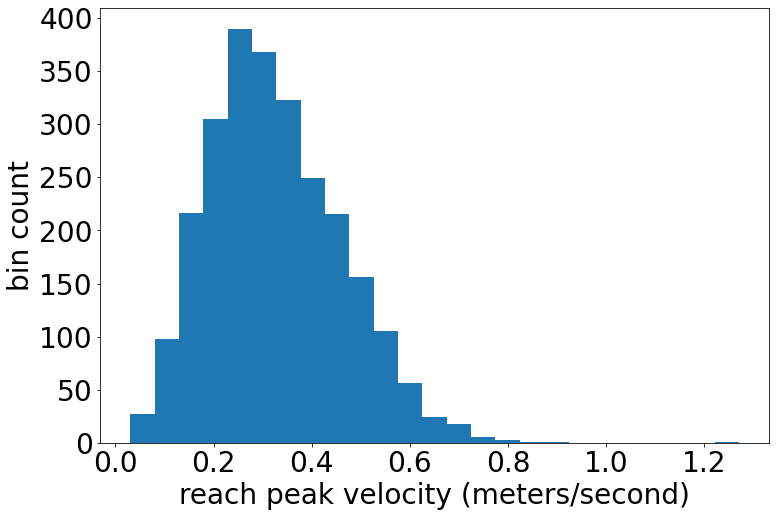

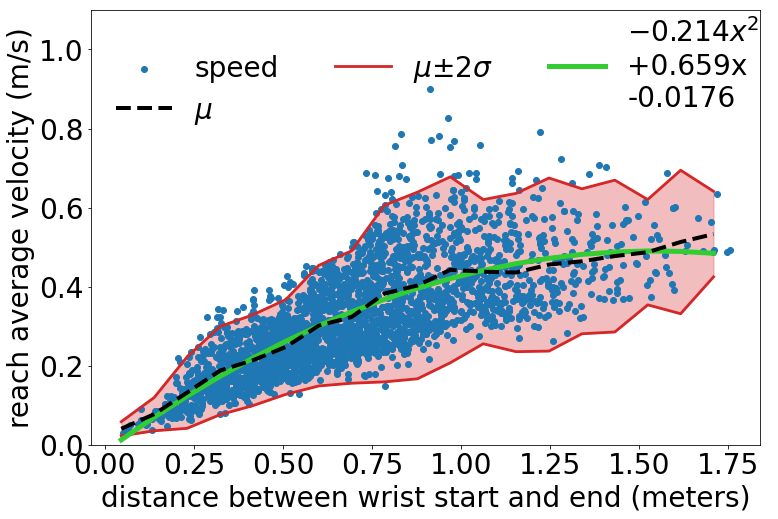

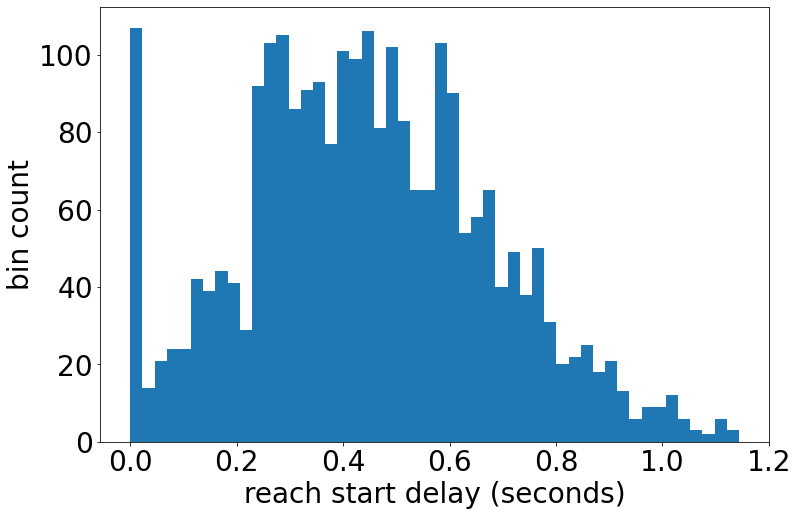

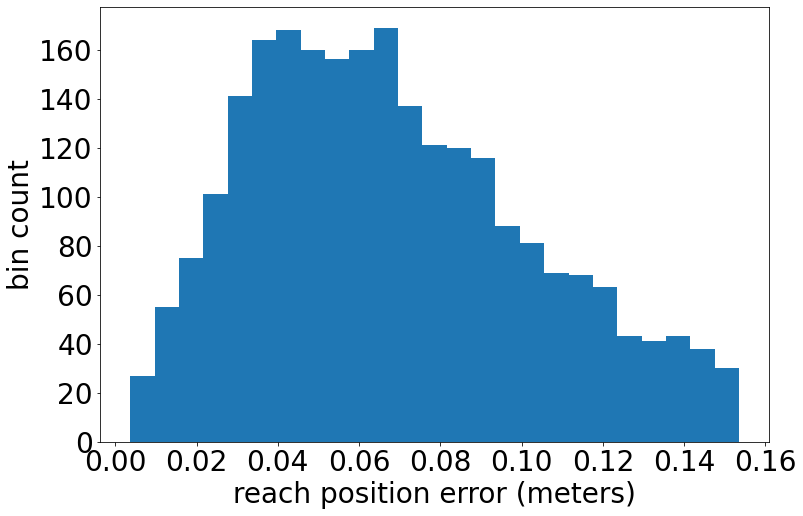

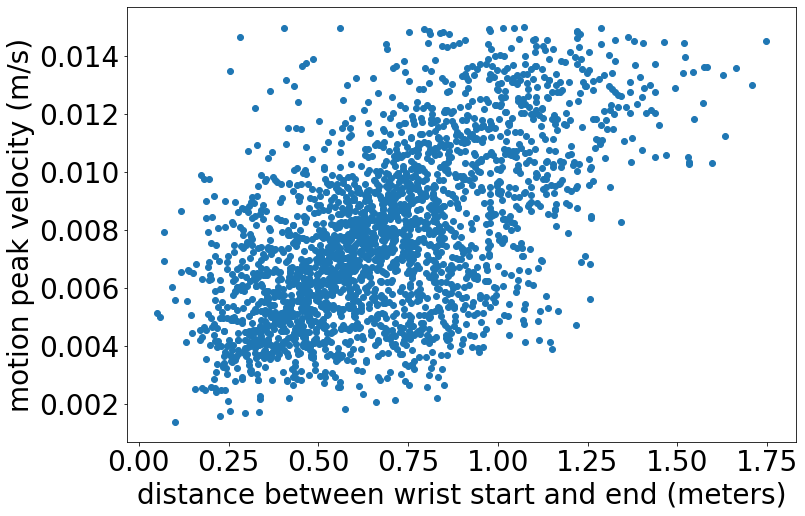

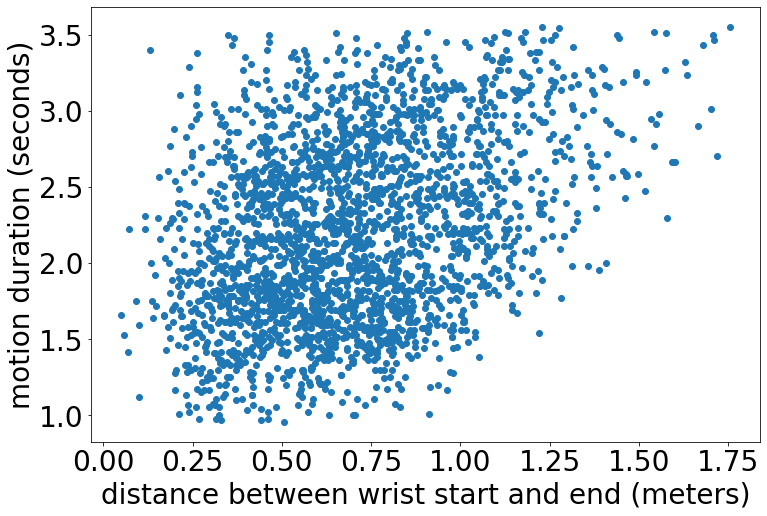

In [73]:
if len(file_nums)>1:
    print('avg final error:{}'.format(np.mean(final_errors)))
    print('avg speed:{}'.format(np.mean(speeds)))
    print('avg start delay:{}'.format(np.mean(start_delays)))
    
    print(dists.shape)
    dists_less_one = dists[dists<30.]
    speeds_dist_less_one = speeds[dists<30]
    sorted_ids = dists_less_one.argsort()
    ordered_dists = dists_less_one[sorted_ids].flatten()
    ordered_speeds = speeds_dist_less_one[sorted_ids].flatten()
    print(ordered_dists.shape)
    y_id = np.arange(ordered_dists.shape[0])
    print(y_id)
    num_rejects = 0
    z = None
    resids=None
    rank=None
    s=None
    rcond=None
    while True:
        z, resids, rank, s, rcond = np.polyfit(ordered_dists[y_id], ordered_speeds[y_id], 2,full=True)
        error = z[0]*np.square(ordered_dists[y_id])+z[1]*ordered_dists[y_id]+z[2]-ordered_speeds[y_id]
#         s_xy = math.sqrt((np.sum(np.square(ordered_speeds[y_id]))-z[1]*np.sum(ordered_speeds[y_id])-z[0]*np.sum(np.multiply(ordered_dists[y_id],ordered_speeds[y_id])))/(y_id.shape[0]-2))
        s_xy = math.sqrt(np.sum(np.square(error))/(y_id.shape[0]-2))
        residual = error/s_xy
        possible_outliers = np.where(np.abs(residual)>2.0)[0]
        max_residual_idx = possible_outliers[0]
        no_rejections = True
        for i in range(possible_outliers.shape[0]):
            j = possible_outliers[0]
            reject = True
            #consistency with neighbors
            if j>0:
                if (abs(residual[j]-residual[j-1])<0.5):
                    reject=False
            if j<possible_outliers.shape[0]-1:
                if (abs(residual[j]-residual[j+1])<0.5):
                    reject=False
            if reject and abs(residual[j]>=residual[max_residual_idx]):
                max_residual_idx = j
                no_rejections = False
        if no_rejections:
            break
        num_rejects += 1
        print('reject {}'.format(y_id[max_residual_idx]))
        y_mask = np.ones_like(y_id, dtype=bool)
        y_mask[max_residual_idx] = False
        y_id = y_id[y_mask]
    print(y_id)
    print(num_rejects)
    print('fit residual:{}'.format(rcond))
    fig = plt.figure(figsize=(12,8))
    speeds_no_outlier_ids = np.arange(0,speeds.shape[0])#np.where(np.abs(speeds-np.mean(speeds))<2*np.std(speeds))[0]
    plt.hist(speeds, bins=25)
    plt.xlabel('reach peak velocity (meters/second)',fontsize=28)
    plt.ylabel('bin count',fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    fig14 = plt.figure(figsize=(12,8))
    deviations = np.empty((0,3))
    ordered_dists = ordered_dists[y_id]
    ordered_speeds = ordered_speeds[y_id]
#     z = np.polyfit(ordered_dists[ordered_dists<1.0], ordered_speeds[ordered_dists<1.0], 1)
    int_size = 50
    i = 0
    best_fit_ln = np.empty((0))
    last_i = 0
    num_bins = 20
    bins = np.linspace(0,ordered_dists[-1],num_bins)
    for i in range(bins.shape[0]-1):
        x = 0.5*(bins[i]+bins[i+1])
        ids = ordered_dists<bins[i+1]
        ids = np.logical_and(ids,ordered_dists>bins[i])
        mu = np.mean(ordered_speeds[ids])
        s = np.std(ordered_speeds[ids])
        deviations = np.append(deviations,np.array([x,mu,s]).reshape((1,3)),axis=0)
        best_fit_ln = np.append(best_fit_ln,z[0]*x*x+z[1]*x+z[2])
        
#     while i<ordered_dists.shape[0]:
#         x = ordered_dists[i]
#         mu = np.mean(ordered_speeds[i:i+int_size])
#         s = np.std(ordered_speeds[i:i+int_size])
#         deviations = np.append(deviations,np.array([x,mu,s]).reshape((1,3)),axis=0)
#         best_fit_ln = np.append(best_fit_ln,z[0]*x+z[1])
#         i+=int_size
#         if int_size<50:
#             int_size += 5
        
    plt.fill_between(deviations[:,0],deviations[:,1]-2*deviations[:,2],deviations[:,1]+2*deviations[:,2],color='tab:red',alpha=0.3)
    plt.scatter(ordered_dists,ordered_speeds,label=r'speed')
    plt.plot(deviations[:,0],deviations[:,1],color='black',linestyle='dashed',linewidth=4.0,label=r'$\mu$',zorder=10)
    plt.plot(deviations[:,0],deviations[:,1]+2*deviations[:,2],color='tab:red',linewidth=2.8,label=r'$\mu$'+u'\u00B1'+r'$2\sigma$')
    plt.plot(deviations[:,0],deviations[:,1]-2*deviations[:,2],color='tab:red',linewidth=2.8)
    plt.plot(deviations[:,0],best_fit_ln,color='limegreen',linewidth=5.0,label=r'${:+.3}x^2$'.format(z[0])+'\n{:+.3}x\n{:+.3}'.format(z[1],z[2]))
    plt.xlabel('distance between wrist start and end (meters)',fontsize=28)
    plt.ylabel('reach average velocity (m/s)',fontsize=28)
    plt.legend(fontsize=28,ncol=3,framealpha=0.0,edgecolor='white',loc='upper left', bbox_to_anchor=(0.0, 1.04))
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim([0,1.1])
    fig10 = plt.figure(figsize=(12,8))
    plt.hist(start_delays[np.abs(start_delays-np.mean(start_delays))<2*np.std(start_delays)], bins=50)
    plt.xlabel('reach start delay (seconds)',fontsize=28)
    plt.ylabel('bin count',fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    fig11 = plt.figure(figsize=(12,8))
    final_errors_no_outliers = np.copy(final_errors[np.abs(final_errors-np.mean(final_errors))<2*np.std(final_errors)])
    print('reach position error {}'.format(np.mean(final_errors_no_outliers)))
    plt.hist(final_errors_no_outliers, bins=25)
    plt.xlabel('reach position error (meters)',fontsize=28)
    plt.ylabel('bin count',fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    fig12 = plt.figure(figsize=(12,8))
    peak_vels_no_outlier_ids = np.where(np.abs(peak_vels-np.mean(peak_vels))<2*np.std(peak_vels))[0]
    plt.scatter(dists[peak_vels_no_outlier_ids],peak_vels[peak_vels_no_outlier_ids])
    plt.xlabel('distance between wrist start and end (meters)',fontsize=28)
    plt.ylabel('motion peak velocity (m/s)',fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    fig13 = plt.figure(figsize=(12,8))
    durations_no_outlier_ids = np.where(np.abs(durations-np.mean(durations))<2*np.std(durations))[0]
    plt.scatter(dists[durations_no_outlier_ids],durations[durations_no_outlier_ids])
    plt.xlabel('distance between wrist start and end (meters)',fontsize=28)
    plt.ylabel('motion duration (seconds)',fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.show()

plotting right errors
reject, acc var:1.3458206735158933e-08


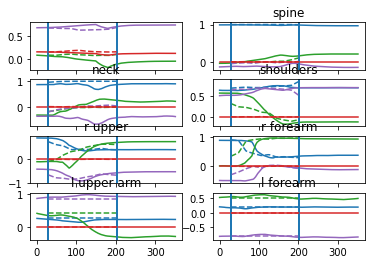

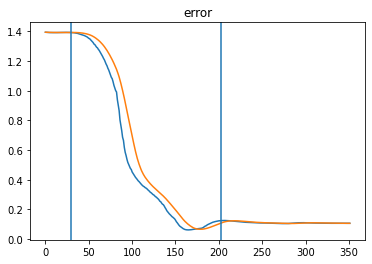

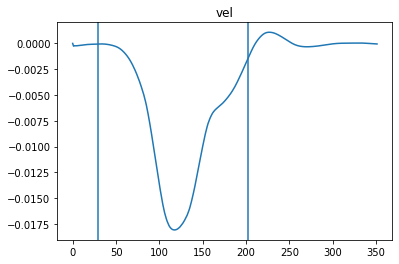

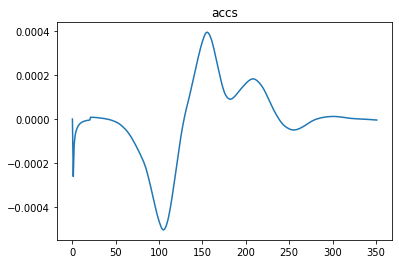

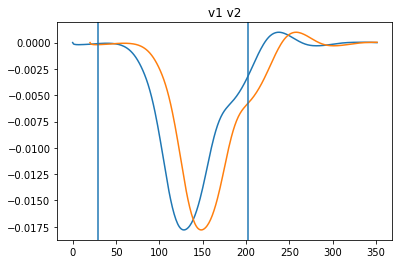

In [4]:
fig5,ax5 = plt.subplots(4,2,sharex = True, sharey=False)
ax5 = ax5.flatten()
if 0:
    x = np.arange(data.shape[0])*0.01
    pred_x = np.arange(prediction.shape[0])*0.1
else:
    x = np.arange(data.shape[0])
    pred_x = np.linspace(d_start,d_stop,prediction.shape[0])
labels = ['spine','neck', 'shoulders','r upper', 'r forearm', 'l upper arm', 'l forearm']
colors = ['tab:blue','tab:green','tab:purple','tab:red']
for i in range(3):
    ax5[0].plot(x,data[:,5+i],color=colors[i+1])
    ax5[0].axvline(d_start)
    ax5[0].axvline(d_stop)
    ax5[0].plot(pred_x,prediction[:,1+i],linestyle='dashed',color=colors[i+1])
for i in range(7):
    for j in range(4):
        ax5[i+1].set_title(labels[i])
        ax5[i+1].plot(x,data[:,8+j+i*4],color=colors[j])
        ax5[i+1].axvline(d_start)
        ax5[i+1].axvline(d_stop)
        ax5[i+1].plot(pred_x,prediction[:,4+j+i*4],linestyle='dashed',color=colors[j])
fig8,ax8 = plt.subplots(1,1,sharex = True, sharey=False)
if wrist:
    ax8.plot(l_wrist_errors)
    ax8.plot(l_wrist_error_avg)
else:
    print('plotting right errors')
    ax8.plot(r_wrist_errors)
    ax8.plot(r_wrist_error_avg)
ax8.axvline(d_start)
ax8.axvline(d_stop)
ax8.set_title('error')

fig6,ax6 = plt.subplots(1,1,sharex = True, sharey=False)
if wrist:
    ax6.plot(l_wrist_error_vels_avg)
else:
    ax6.plot(r_wrist_error_vels_avg)
ax6.axvline(d_start)
ax6.axvline(d_stop)
ax6.set_title('vel')

fig9,ax9 = plt.subplots(1,1,sharex = True, sharey=False)
ax9.plot(accs)
ax9.set_title('accs')
print('{}, acc var:{}'.format('accept' if (acc_var<1E-9) and (final_error<0.2) else 'reject',acc_var))

fig7,ax7 = plt.subplots(1,1,sharex = True, sharey=False)
ax7.plot(v1s)
ax7.plot(v2s)
ax7.axvline(d_start)
ax7.axvline(d_stop)
ax7.set_title('v1 v2')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print('{},{}'.format(data.shape[0],prediction.shape[0]))
colors = pl.cm.winter(np.linspace(0,1,prediction.shape[0]))
colors2 = pl.cm.jet(np.linspace(0,1,data.shape[0]))
reaching_tgt = data[0,1:4]
ax.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
for i in range(prediction.shape[0]):
    c_ = colors[i]
    ax.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed')
    ax.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed')
for i in range(data.shape[0]):
    c_ = colors2[i]
    act_data = data
    ax.plot([act_data[i,36],act_data[i,39]],[act_data[i,37],act_data[i,40]],[act_data[i,38],act_data[i,41]],c=c_)
    ax.plot([act_data[i,42],act_data[i,39]],[act_data[i,43],act_data[i,40]],[act_data[i,44],act_data[i,41]],c=c_)
    ax.plot([act_data[i,45],act_data[i,39]],[act_data[i,46],act_data[i,40]],[act_data[i,47],act_data[i,41]],c=c_)
    ax.plot([act_data[i,45],act_data[i,48]],[act_data[i,46],act_data[i,49]],[act_data[i,47],act_data[i,50]],c=c_)
    ax.plot([act_data[i,51],act_data[i,48]],[act_data[i,52],act_data[i,49]],[act_data[i,53],act_data[i,50]],c=c_)
    ax.plot([act_data[i,54],act_data[i,39]],[act_data[i,55],act_data[i,40]],[act_data[i,56],act_data[i,41]],c=c_)
    ax.plot([act_data[i,54],act_data[i,57]],[act_data[i,55],act_data[i,58]],[act_data[i,56],act_data[i,59]],c=c_)
    ax.plot([act_data[i,60],act_data[i,57]],[act_data[i,61],act_data[i,58]],[act_data[i,62],act_data[i,59]],c=c_)


fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax2.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors[i]
ax2.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
c_ = colors2[i]
ax2.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax2.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
i=-1
c_ = colors[prediction.shape[0]-1]
ax2.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax2.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
c_ = colors2[data.shape[0]-1]
ax2.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax2.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax2.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
for i in range(prediction.shape[0]-1):
    c_ = colors[i]
    for j in range(9):
        ax2.plot([prediction[i,j*3+32],prediction[i+1,j*3+32]],[prediction[i,j*3+33],prediction[i+1,j*3+33]],[prediction[i,j*3+34],prediction[i+1,j*3+34]],c=c_,ls=(0, (1, 10)))

for i in range(data.shape[0]-1):
    c_ = colors2[i]
    for j in range(9):
        ax2.plot([data[i,j*3+36],data[i+1,j*3+36]],[data[i,j*3+37],data[i+1,j*3+37]],[data[i,j*3+38],data[i+1,j*3+38]],c=c_,ls=(0, (5, 10)))


fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax3.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors[i]
ax3.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)

i=-1
c_ = colors[prediction.shape[0]-1]
ax3.plot([prediction[i,32],prediction[i,35]],[prediction[i,33],prediction[i,36]],[prediction[i,34],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,38],prediction[i,35]],[prediction[i,39],prediction[i,36]],[prediction[i,40],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,35]],[prediction[i,42],prediction[i,36]],[prediction[i,43],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,41],prediction[i,44]],[prediction[i,42],prediction[i,45]],[prediction[i,43],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,47],prediction[i,44]],[prediction[i,48],prediction[i,45]],[prediction[i,49],prediction[i,46]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,35]],[prediction[i,51],prediction[i,36]],[prediction[i,52],prediction[i,37]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,50],prediction[i,53]],[prediction[i,51],prediction[i,54]],[prediction[i,52],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
ax3.plot([prediction[i,56],prediction[i,53]],[prediction[i,57],prediction[i,54]],[prediction[i,58],prediction[i,55]],c=c_,linestyle='dashed', linewidth=1.5)
for i in range(prediction.shape[0]-1):
    c_ = colors[i]
    for j in range(9):
        ax3.plot([prediction[i,j*3+32],prediction[i+1,j*3+32]],[prediction[i,j*3+33],prediction[i+1,j*3+33]],[prediction[i,j*3+34],prediction[i+1,j*3+34]],c=c_,ls=(0, (1, 10)))

fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d')
reaching_tgt = data[0,1:4]
ax4.scatter(reaching_tgt[0],reaching_tgt[1],reaching_tgt[2],color='tab:red')
i=0
c_ = colors2[i]
ax4.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax4.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)
i=-1
c_ = colors2[data.shape[0]-1]
ax4.plot([data[i,36],data[i,39]],[data[i,37],data[i,40]],[data[i,38],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,42],data[i,39]],[data[i,43],data[i,40]],[data[i,44],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,39]],[data[i,46],data[i,40]],[data[i,47],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,45],data[i,48]],[data[i,46],data[i,49]],[data[i,47],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,51],data[i,48]],[data[i,52],data[i,49]],[data[i,53],data[i,50]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,39]],[data[i,55],data[i,40]],[data[i,56],data[i,41]],c=c_, linewidth=1.5)
ax4.plot([data[i,54],data[i,57]],[data[i,55],data[i,58]],[data[i,56],data[i,59]],c=c_, linewidth=1.5)
ax4.plot([data[i,60],data[i,57]],[data[i,61],data[i,58]],[data[i,62],data[i,59]],c=c_, linewidth=1.5)

for i in range(data.shape[0]-1):
    c_ = colors2[i]
    for j in range(9):
        ax4.plot([data[i,j*3+36],data[i+1,j*3+36]],[data[i,j*3+37],data[i+1,j*3+37]],[data[i,j*3+38],data[i+1,j*3+38]],c=c_,ls=(0, (5, 10)))
plt.show()

In [ ]:
ang = pi/2
q = np.array([math.cos(ang/2),0,0,sin(ang/2)])
q = q/np.linalg.norm(q)
q2 = np.array([math.cos(ang/2),0,0,0])